## Introduction

Goal of project: predict a location's risk level of becoming a food desert based on 10 features (which will be decided later)

will perform a combination of supervised and unsupervised machine learning methods to further understand the food desert problem and create a prediciton model for the likelihood of a person living in a food desert


## Data Exploration and Cleaning 

Data set found here: https://www.kaggle.com/tcrammond/food-access-and-food-deserts/version/1

From the dataset, we have the census tract number which is the primary basis of location, a binary flag that identifies food deserts, median family income for the census tract, and population count, and distance count for grocery stores among other variables.


Dataset is comprised of all US Census Bureau defined land "tracts" in the US with feature information related to demographics of the area and levels of food insecurity. 

We want to focus on Virginia and generalize onto food deserts within the state. Hence the full Kaggle dataset has been subsetted to 1,900 instances rather than 72,000. The 1,900 instances represent Virginia tract of lands. 

Additionally, feature engineering is performed to narrow down features as that will allow for greater generalization and prevent our model from overfitting

#### Data Exploration/import

In [ ]:
import sklearn
import numpy as np
import os
import matplotlib.pyplot as matplotlib
import matplotlib.pyplot as plt
import pandas as pd

#import data (loaded it into files and is titled food_access_research_atlas.csv )

food_access = pd.read_csv('/content/food_access_research_atlas.csv')
print(food_access)

       CensusTract    State    County  ...  TractHispanic  TractHUNV  TractSNAP
0       1001020100  Alabama   Autauga  ...             44         26        112
1       1001020200  Alabama   Autauga  ...             75         87        202
2       1001020300  Alabama   Autauga  ...             87        108        120
3       1001020400  Alabama   Autauga  ...             85         19         82
4       1001020500  Alabama   Autauga  ...            355        198        488
...            ...      ...       ...  ...            ...        ...        ...
72859  56043000200  Wyoming  Washakie  ...            309         56        116
72860  56043000301  Wyoming  Washakie  ...            446        114        124
72861  56043000302  Wyoming  Washakie  ...            407         82         97
72862  56045951100  Wyoming    Weston  ...             91        108         50
72863  56045951300  Wyoming    Weston  ...            125         95        168

[72864 rows x 147 columns]


In [ ]:
print(food_access.info())
#from this we know we have all but 2 features that are not numerical

print(food_access.isna().sum())
print()
print(food_access.isna().sum().sum())

#therefore we have no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72864 entries, 0 to 72863
Columns: 147 entries, CensusTract to TractSNAP
dtypes: float64(112), int64(33), object(2)
memory usage: 81.7+ MB
None
CensusTract      0
State            0
County           0
Urban            0
POP2010          0
                ..
TractAIAN        0
TractOMultir     0
TractHispanic    0
TractHUNV        0
TractSNAP        0
Length: 147, dtype: int64

0


In [ ]:
#basic data visualizations/information
food_access.describe()

,CensusTract,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,...,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
count,7.286400e+04,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,...,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000,72864.000000
mean,2.783045e+10,0.757191,4237.285052,1601.837560,0.007082,109.619606,0.026961,0.126880,0.282115,0.111235,0.149168,0.223897,0.423666,16.566941,67431.742342,0.377786,0.682436,0.339125,0.638450,0.333800,0.043986,0.005325,0.228343,950.630801,2126.394638,888.393258,277.523679,683.163017,253.161368,2964.627204,0.686544,958.241015,0.230569,721.945777,0.162620,395.213485,0.096416,2274.206888,0.524695,334.480852,...,3.710033,0.003116,8.710264,0.003697,4.014367,0.001607,2.126046,0.000860,1.491475,0.000659,5.921694,0.002711,0.095017,0.000033,0.052508,0.000022,0.010091,0.000015,2.113990,0.000697,0.516964,0.000219,0.960206,0.000381,0.281904,0.000323,0.482634,0.000517,1451.249067,1018.081179,552.645806,3068.089386,534.273702,201.392347,7.411246,40.242754,385.875618,692.764520,145.356239,207.022206
std,1.581256e+10,0.428783,1972.520112,732.106217,0.083855,442.922669,0.095494,0.332841,0.450032,0.314425,0.356257,0.416856,0.494142,12.921510,34086.543504,0.484837,0.465532,0.473416,0.480453,0.471572,0.205066,0.072778,0.419768,1598.462863,2128.378536,1598.486855,541.196236,814.424313,533.514218,2101.964909,0.334816,853.589869,0.176904,600.012360,0.092710,334.345461,0.075406,1820.944741,0.324575,662.550887,...,22.430761,0.019475,127.614864,0.048988,69.777243,0.023593,36.964018,0.012363,21.586629,0.009222,83.954486,0.038073,6.263403,0.001511,3.423152,0.001192,0.735939,0.003185,75.959829,0.020821,11.761746,0.004494,29.146206,0.010002,9.247592,0.008952,9.915605,0.009720,1015.600836,617.951460,352.988078,1804.353298,887.806852,435.085612,45.084789,181.024758,528.776237,1117.876349,230.201932,187.188807
min,1.001020e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [ ]:
print(food_access['State'])

0        Alabama
1        Alabama
2        Alabama
3        Alabama
4        Alabama
          ...   
72859    Wyoming
72860    Wyoming
72861    Wyoming
72862    Wyoming
72863    Wyoming
Name: State, Length: 72864, dtype: object


In [ ]:
#now let's keep only virginia data
food_access_va_bool = food_access['State'] == "Virginia"
food_access_va = food_access[food_access_va_bool]
print(food_access_va.head())
#now let's split the data set (the original will be used for unsupervised)
# however, splitting is needed for the supervised models

       CensusTract     State    County  ...  TractHispanic  TractHUNV  TractSNAP
67498  51001090100  Virginia  Accomack  ...             49        141         66
67499  51001090200  Virginia  Accomack  ...            179        110        275
67500  51001090300  Virginia  Accomack  ...            152        111        228
67501  51001090400  Virginia  Accomack  ...           1486        170        495
67502  51001090500  Virginia  Accomack  ...            405        138         95

[5 rows x 147 columns]


In [ ]:
food_access_va[food_access_va['lalowi1share']==food_access_va['lalowi1share'].max()]['lalowi1share']

67507    1.0
Name: lalowi1share, dtype: float64

#### Data Cleaning

There is no need for data cleaning (aside from feature engineering) since we are only looking at virginia dataset and there are no missing values. Once the features to keep are decided, a pipeline will be created

#### Feature Engineering


High correlation between 2 variables means they have similar trends and are likely to carry similar information. This can bring down the performance of some models drastically (linear and logistic regression). Hence, we will calculate the correlation between independent numerical variables that are numerical in nature. If the correlation coefficient crosses a certain threshold value, we can drop 1 of the variables. 

In [ ]:
#high correlation filter
numerical_values = food_access_va.select_dtypes(['number'])

correlation = numerical_values.corr().abs()
numeric_columns = numerical_values.columns
high_corr = []


for c1 in numeric_columns:
  for c2 in numeric_columns:
    if c1 != c2 and c2 not in high_corr and correlation[c1][c2] > 0.7:
      high_corr.append(c1)

#only keeping the upper triangle since correlation matrix will be mirror image about the diagonal and 
#all diagonal elements will be 1
upper_tri = correlation.where(np.triu(np.ones(correlation.shape),k=1).astype(np.bool))
#print(upper_tri)

#dropping the column with high correlation
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
#print(to_drop)
print("length", len(to_drop))

#dropping the columns 
corr_df = food_access_va.drop(to_drop, axis =1 )
corr_df = corr_df.drop("State",axis =1 )
print(corr_df)

length 119
       CensusTract      County  Urban  ...  lanhopi10  lanhopi20  lanhopi20share
67498  51001090100    Accomack      0  ...        0.0        0.0             0.0
67499  51001090200    Accomack      0  ...        0.0        0.0             0.0
67500  51001090300    Accomack      0  ...        0.0        0.0             0.0
67501  51001090400    Accomack      0  ...        0.0        0.0             0.0
67502  51001090500    Accomack      0  ...        0.0        0.0             0.0
...            ...         ...    ...  ...        ...        ...             ...
69393  51840000100  Winchester      1  ...        0.0        0.0             0.0
69394  51840000201  Winchester      1  ...        0.0        0.0             0.0
69395  51840000202  Winchester      1  ...        0.0        0.0             0.0
69396  51840000301  Winchester      1  ...        0.0        0.0             0.0
69397  51840000302  Winchester      1  ...        0.0        0.0             0.0

[1900 rows x 27 

In [ ]:
#want to remove lanhopie20 and lanhopie20share since only 1 unique value
corr_df = corr_df.drop(["lanhopi20","lanhopi20share"],axis =1)
print(corr_df.nunique())

CensusTract             1900
County                   134
Urban                      2
POP2010                 1599
GroupQuartersFlag          2
NUMGQTRS                 345
LILATracts_1And10          2
LILATracts_halfAnd10       2
LILATracts_Vehicle         2
PovertyRate              395
MedianFamilyIncome      1786
LA1and10                   2
LATracts10                 2
LATracts20                 2
LALOWI05_10             1506
lapophalfshare          1516
lalowihalf              1834
lablackhalf             1836
laasianhalf             1789
lanhopihalf              916
laaianhalf              1706
laomultirhalf           1835
laasian1                1360
laomultir1              1419
lanhopi10                 21
dtype: int64


In [ ]:
corr_df.dtypes
num_corr_df = corr_df.drop(["County"], axis = 1)

This method drops 119 features when using a threshold of 0.7. meaning we have 24 columns (one of which is the target variable) left with 1900 instances

We want to further remove any features with high variance so we ran the low variance filter. All the variances were extremely low, so no additional features were removed.

In [ ]:
#low variance filtering 
from sklearn.preprocessing import normalize
#normalize the data
normalize = normalize(num_corr_df)
data_scaled = pd.DataFrame(normalize)
variance = data_scaled.var()
columns = num_corr_df.columns

variable = [ ]

for i in range(0,len(variance)):
    if variance[i]>=0.006: #setting the threshold as 1%
        variable.append(columns[i])

print(variance)

#variance is very low for all, so not removing anymore features


0     3.534095e-24
1     7.647982e-23
2     1.230107e-15
3     4.732972e-24
4     1.523631e-16
5     4.776390e-23
6     7.777221e-23
7     5.373601e-23
8     4.991215e-20
9     7.501972e-13
10    8.981303e-23
11    1.508617e-23
12    2.016235e-25
13    1.528175e-16
14    3.446039e-23
15    1.904029e-16
16    2.116689e-16
17    2.397459e-17
18    5.738936e-21
19    7.405068e-20
20    1.186743e-17
21    4.512171e-18
22    3.495282e-18
23    3.391710e-23
dtype: float64


<function matplotlib.pyplot.show>

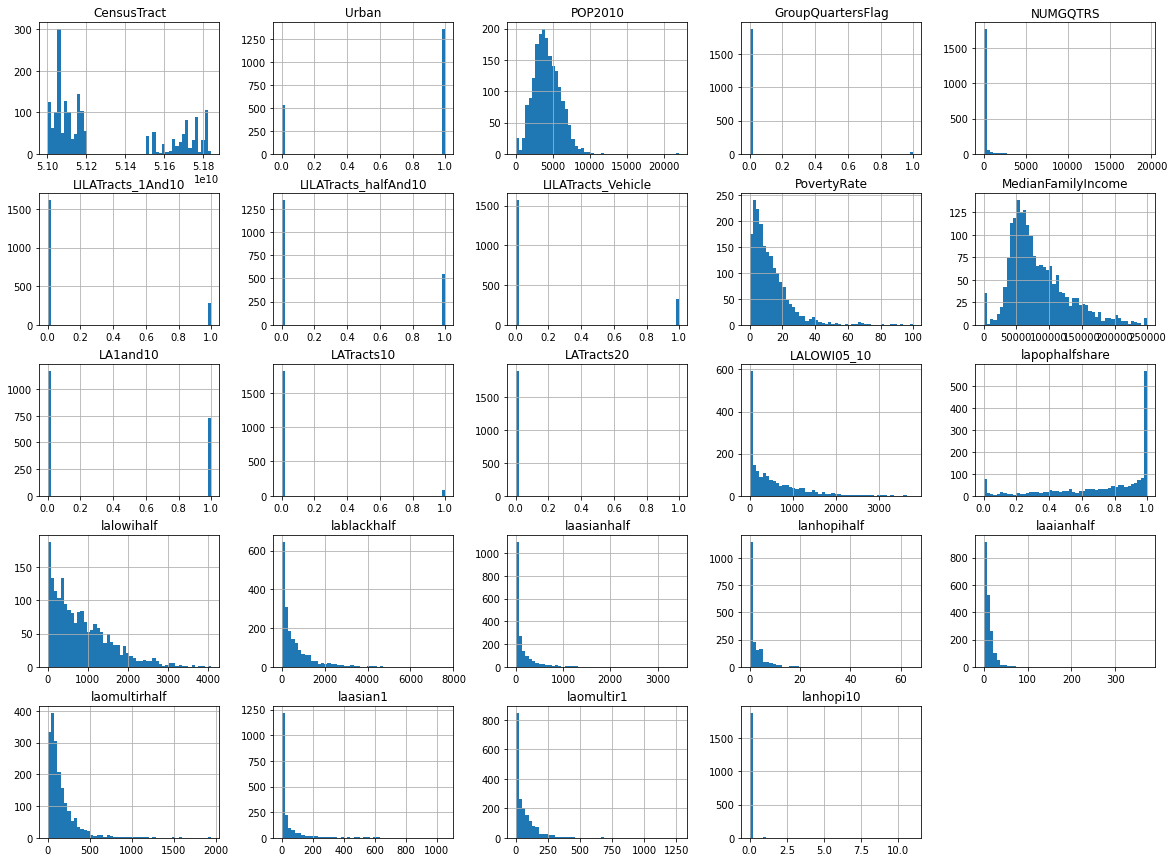

In [ ]:
#pipeline
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(corr_df, test_size=.2, random_state =42)
test_set.head()
corr_df.hist(bins=50,figsize=(20,15))
plt.show

As seen in the histograms above, mose of the data is skewed to the right with POP2010 being the histogram closest to a normal histogram.

In [ ]:
string_values = food_access_va.select_dtypes(exclude = ['number'])
print(string_values)
#since it is all in virginia, we will drop state and only include county

          State      County
67498  Virginia    Accomack
67499  Virginia    Accomack
67500  Virginia    Accomack
67501  Virginia    Accomack
67502  Virginia    Accomack
...         ...         ...
69393  Virginia  Winchester
69394  Virginia  Winchester
69395  Virginia  Winchester
69396  Virginia  Winchester
69397  Virginia  Winchester

[1900 rows x 2 columns]


In [ ]:
train_set

,CensusTract,County,Urban,POP2010,GroupQuartersFlag,NUMGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_Vehicle,PovertyRate,MedianFamilyIncome,LA1and10,LATracts10,LATracts20,LALOWI05_10,lapophalfshare,lalowihalf,lablackhalf,laasianhalf,lanhopihalf,laaianhalf,laomultirhalf,laasian1,laomultir1,lanhopi10
68503,51153901237,Prince William,1,3076,0,0,0,0,0,9.7,128098,0,0,0,92.790726,0.159133,92.790726,135.761707,24.457868,0.556310,3.416158,60.810694,0.000000,0.000000,0.0
69292,51810040802,Virginia Beach,1,4771,0,3,0,1,0,12.8,57639,0,0,0,1104.250943,0.770666,1104.250943,953.291466,275.525797,1.000000,30.095591,261.834480,0.000000,0.000000,0.0
69273,51800075404,Suffolk,0,935,0,0,0,0,0,1.3,102917,0,0,0,0.000000,0.996435,107.463093,102.999998,7.000000,0.000000,7.000000,4.000000,6.000000,4.000000,0.0
67837,51059422000,Fairfax,1,3439,0,111,0,0,0,5.0,146029,1,0,0,532.525036,1.000000,532.525036,787.000009,483.000000,1.000000,7.000000,409.999998,209.653489,133.782129,0.0
68322,51107611101,Loudoun,1,4329,0,0,0,0,0,2.3,106667,1,0,0,340.996091,0.885997,340.996091,286.605798,493.061166,3.891200,13.000000,398.152252,114.742823,165.835702,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68628,51177020106,Spotsylvania,0,5781,0,107,0,0,0,2.6,98281,0,0,0,0.000000,0.729010,867.152230,363.408789,166.846915,2.496359,7.526600,184.639403,130.494055,126.131702,0.0
68792,51510201900,Alexandria,1,1679,0,70,0,0,0,5.7,145500,0,0,0,0.004482,0.000065,0.004482,0.109920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
68358,51115951400,Mathews,0,4577,0,86,0,0,0,6.0,85547,0,0,0,0.000000,0.939584,944.638192,418.994408,12.000000,0.000000,12.000000,88.234750,12.000000,75.355818,0.0
68957,51680000600,Lynchburg,1,3220,0,600,1,1,1,28.9,28836,1,0,0,2089.738649,1.000000,2089.738649,2534.000010,8.000000,0.000000,4.000000,89.000000,8.000000,63.388701,0.0


## Classification 

In [ ]:
#PIPELINE for binary classification (dropping LILATracts_1And10)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
#print(housing_num.info())

x_train = train_set
y_train = x_train["LILATracts_1And10"]
x_train = x_train.drop("LILATracts_1And10",axis =1 )

# #preparing test set
x_test = test_set
y_test = x_test["LILATracts_1And10"]
x_test = x_test.drop("LILATracts_1And10",axis=1)

temp = corr_df.drop("County",axis=1)
temp = temp.drop("LILATracts_1And10",axis = 1)
cat_attribs = ["County","Urban","GroupQuartersFlag","LILATracts_halfAnd10","LILATracts_Vehicle","LA1and10","LATracts10","LATracts20"]
corr_df
temp = temp.drop(cat_attribs[1:],axis=1)#["Urban","GroupQuartersFlag","LILATracts_halfAnd10","LILATracts_Vehicle","LA1and10","LATracts10","LATracts20"],axis =1)
num_attribs = list(temp)
print(num_attribs)


num_pipeline = Pipeline([
                         ('imputer' , SimpleImputer(strategy = "median")),
                         ('std_scaler',StandardScaler()),
                                       
])


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])



food_desert_prepared = full_pipeline.fit_transform(x_train)
food_desert_test_prepared = full_pipeline.transform(x_test)

['CensusTract', 'POP2010', 'NUMGQTRS', 'PovertyRate', 'MedianFamilyIncome', 'LALOWI05_10', 'lapophalfshare', 'lalowihalf', 'lablackhalf', 'laasianhalf', 'lanhopihalf', 'laaianhalf', 'laomultirhalf', 'laasian1', 'laomultir1', 'lanhopi10']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Support Vector Machine Classifiers
linearSVM = SVC(kernel="linear",C=0.02)
polySVM = SVC(kernel="poly",degree=3)
rbfSVM = SVC(kernel="rbf",gamma=0.5,C=0.02)

#fitting  train data in SVMs
linearSVM.fit(food_desert_prepared,y_train)
polySVM.fit(food_desert_prepared, y_train)
rbfSVM.fit(food_desert_prepared,y_train)

#predict

y_pred_linearSVM = linearSVM.predict(food_desert_test_prepared)
y_pred_polySVM = polySVM.predict(food_desert_test_prepared)
y_pred_rbfSVM = rbfSVM.predict(food_desert_test_prepared)

#Confusion Matrix
print("Confusion Matrix Linear SVM: ", confusion_matrix(y_test,y_pred_linearSVM))
print("Confusion Matrix Polynomial SVM: ", confusion_matrix(y_test,y_pred_polySVM))
print("Confusion Matrix RBF SVM: ", confusion_matrix(y_test,y_pred_rbfSVM))

#Precision
print("Precision Score Linear SVM: ", precision_score(y_test,y_pred_linearSVM))
print("Precision Score Polynomial SVM: ", precision_score(y_test,y_pred_polySVM))
print("Precision Score RBF SVM: ", precision_score(y_test,y_pred_rbfSVM))

#Recall
print("Recall Score Linear SVM: ", recall_score(y_test,y_pred_linearSVM))
print("Recall Score Polynomial SVM: ", recall_score(y_test,y_pred_polySVM))
print("Recall Score RBF SVM: ", recall_score(y_test,y_pred_rbfSVM))


#KNeighbors Classifier
Kneighbor = KNeighborsClassifier(n_neighbors=2) #does 2 neighbors signify the two possible labels? 
Kneighbor.fit(food_desert_prepared,y_train)

#predict
y_pred_kn = Kneighbor.predict(food_desert_test_prepared)

#Confusion Matrix
print("Confusion Matrix for Kneighbors: ", confusion_matrix(y_test,y_pred_kn))

#Recall Score
print("Recall Score for Kneighbors: ", recall_score(y_test,y_pred_kn))

#Precision Score
print("Precision Score for Kneighbors: ", precision_score(y_test,y_pred_kn))

#RandomForestClassifier
RandomForest =  RandomForestClassifier(n_estimators=200)
RandomForest.fit(food_desert_prepared,y_train)

#predict
y_pred_rf = RandomForest.predict(food_desert_test_prepared)

#Confusion Matrix
print("Confusion Matrix for RandomForest: ", confusion_matrix(y_test,y_pred_rf))

#Recall Score
print("Recall Score for RandomForest: ", recall_score(y_test,y_pred_rf))

#Precision Score
print("Precision Score for RandomForest: ", precision_score(y_test,y_pred_rf))

#AdaBoostClassifier
boosted = AdaBoostClassifier()
boosted.fit(food_desert_prepared,y_train)

#predict
y_pred_bc = boosted.predict(food_desert_test_prepared)

#Confusion Matrix
print("Confusion Matrix for Boost: ", confusion_matrix(y_test,y_pred_bc))

#Recall Score
print("Recall Score for Boost: ", recall_score(y_test,y_pred_bc))

#Precision Score
print("Precision Score for Boost: ", precision_score(y_test,y_pred_bc))


Confusion Matrix Linear SVM:  [[324   0]
 [  0  56]]
Confusion Matrix Polynomial SVM:  [[323   1]
 [  2  54]]
Confusion Matrix RBF SVM:  [[324   0]
 [ 56   0]]
Precision Score Linear SVM:  1.0
Precision Score Polynomial SVM:  0.9818181818181818
Precision Score RBF SVM:  0.0
Recall Score Linear SVM:  1.0
Recall Score Polynomial SVM:  0.9642857142857143
Recall Score RBF SVM:  0.0
Confusion Matrix for Kneighbors:  [[322   2]
 [ 19  37]]
Recall Score for Kneighbors:  0.6607142857142857
Precision Score for Kneighbors:  0.9487179487179487


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix for RandomForest:  [[324   0]
 [  0  56]]
Recall Score for RandomForest:  1.0
Precision Score for RandomForest:  1.0
Confusion Matrix for Boost:  [[324   0]
 [  0  56]]
Recall Score for Boost:  1.0
Precision Score for Boost:  1.0


In [ ]:
# does our best model classify areas of Charlottesville as food deserts?

jpa_area = food_access_va.loc[food_access_va['CensusTract'] == 51540000600]
# jpa_area_pipeline = full_pipeline.fit_transform(jpa_area)
# jpa_area_pred_bc = boosted.predict(jpa_area_pipeline)

emmett_street_and_corner_area= food_access_va.loc[food_access_va['CensusTract'] == 51003010903]
# emmett_street_and_corner_area_pipeline = full_pipeline.fit_transform(emmett_street_and_corner_area)
# emmett_street_and_corner_area_pred_bc = boosted.predict(emmett_street_and_corner_area_pipeline)

behind_ohill_area = food_access_va.loc[food_access_va['CensusTract'] == 51003010902]
# behind_ohill_area_pipeline = full_pipeline.fit_transform(behind_ohill_area)
# behind_ohill_area_pred_bc = boosted.predict(behind_ohill_area_pipeline)


result = jpa_area.append(emmett_street_and_corner_area)
result2 = result.append(behind_ohill_area)
#result2.shape


result_pipeline = full_pipeline.transform(result2)
result_pred_bc = polySVM.predict(result_pipeline)
result_pred_bc

array([1, 0, 0])

##Clustering

In [ ]:
# let's plot the food_access_va engineered dataset by smallest unit of location (CensusTract) 
food_access_va.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,...,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
67498,51001090100,Virginia,Accomack,0,2941,1417,0,16,0.005440,0,0,0,0,1,0,11.4,68454,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,2394.946984,0.814331,717.046081,0.243810,376.509132,0.128021,656.125338,0.223096,2278.927537,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,873,454,802,2804,23,17,0,8,89,49,141,66
67499,51001090200,Virginia,Accomack,0,6156,2630,0,15,0.002437,0,0,0,1,1,1,20.4,49257,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,6058.737174,0.984200,2238.699527,0.363661,1204.726824,0.195700,1128.185747,0.183266,3925.686747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2238,1234,1141,3985,1902,39,13,25,192,179,110,275
67500,51001090300,Virginia,Accomack,0,2335,960,0,0,0.000000,0,0,0,0,0,1,21.0,36129,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2335.000012,1.000000,1304.290577,0.558583,521.000002,0.223126,413.000002,0.176874,1735.000009,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1307,521,413,1735,443,9,2,3,143,152,111,228
67501,51001090400,Virginia,Accomack,0,6234,2225,0,296,0.047482,0,0,0,1,1,1,16.8,48836,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,5641.909063,0.905022,2753.881901,0.441752,1372.395200,0.220147,872.405595,0.139943,2917.541227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3234,1530,914,3115,2313,30,10,24,742,1486,170,495
67502,51001090500,Virginia,Accomack,0,2849,1141,0,10,0.003510,0,0,0,1,1,1,22.4,41750,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,2848.999999,1.000000,1648.843804,0.578745,685.000000,0.240435,439.999999,0.154440,1768.999996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1422,685,440,1769,745,27,7,25,276,405,138,95


In [ ]:
import csv
datapath = r"/content/2021_Gaz_tracts_national 2.txt"

data1 = []

with open(datapath) as f:
    reader = csv.reader(f, delimiter="	")
    rows = [row for row in reader]

    for row in rows[1:]:
      if(row[0]=="VA"):
        data1.append(row)

df = pd.DataFrame(data1)
df= df.rename(columns={0:"State", 1:"CensusTract",2:"a",3: "b",4: "c", 5:"d",6: "lat",7: "lon"})
df

,State,CensusTract,a,b,c,d,lat,lon
0,VA,51001090101,11889599,32123347,4.591,12.403,37.9584297,-75.343752 ...
1,VA,51001090102,6652973,5791517,2.569,2.236,37.9084048,-75.3953862 ...
2,VA,51001090201,67750622,33782725,26.159,13.044,37.9744866,-75.4361713 ...
3,VA,51001090202,120052501,2763533,46.353,1.067,37.937326,-75.5614807 ...
4,VA,51001090300,128419397,61780185,49.583,23.853,37.8876208,-75.6629073 ...
...,...,...,...,...,...,...,...,...
2193,VA,51840000102,1570717,0,0.606,0.,39.1874169,-78.1585505 ...
2194,VA,51840000201,4357781,3061,1.683,0.001,39.1963329,-78.1733416 ...
2195,VA,51840000202,5487692,4536,2.119,0.002,39.1835901,-78.1828509 ...
2196,VA,51840000301,3230155,10569,1.247,0.004,39.1733174,-78.1634657 ...


In [ ]:
#food_access_va.info()
df['CensusTract']= df['CensusTract'].astype(str).astype(int)
#df.info()

outer_merged = pd.merge(food_access_va, df, how="outer", on=["CensusTract"])

outer_merged['lat'] = outer_merged['lat'].astype(float)
outer_merged['lon'] = outer_merged['lon'].astype(float)
outer_merged['CensusTract'] = outer_merged['CensusTract'].astype(str)
outer_merged['County'] = outer_merged['County'].astype(str)


cols = list(outer_merged.columns)
cols = [cols[-1]] + cols[:-1]
outer_merged = outer_merged[cols]

cols = list(outer_merged.columns)
cols = [cols[-1]] + cols[:-1]
outer_merged = outer_merged[cols]

outer_merged

,lat,lon,CensusTract,State_x,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,...,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,State_y,a,b,c,d
0,NaN,NaN,51001090100,Virginia,Accomack,0.0,2941.0,1417.0,0.0,16.0,0.005440,0.0,0.0,0.0,0.0,1.0,0.0,11.4,68454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2394.946984,0.814331,717.046081,0.243810,376.509132,0.128021,656.125338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,873.0,454.0,802.0,2804.0,23.0,17.0,0.0,8.0,89.0,49.0,141.0,66.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,51001090200,Virginia,Accomack,0.0,6156.0,2630.0,0.0,15.0,0.002437,0.0,0.0,0.0,1.0,1.0,1.0,20.4,49257.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6058.737174,0.984200,2238.699527,0.363661,1204.726824,0.195700,1128.185747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2238.0,1234.0,1141.0,3985.0,1902.0,39.0,13.0,25.0,192.0,179.0,110.0,275.0,NaN,NaN,NaN,NaN,NaN
2,37.887621,-75.662907,51001090300,Virginia,Accomack,0.0,2335.0,960.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,21.0,36129.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2335.000012,1.000000,1304.290577,0.558583,521.000002,0.223126,413.000002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1307.0,521.0,413.0,1735.0,443.0,9.0,2.0,3.0,143.0,152.0,111.0,228.0,VA,128419397,61780185,49.583,23.853
3,NaN,NaN,51001090400,Virginia,Accomack,0.0,6234.0,2225.0,0.0,296.0,0.047482,0.0,0.0,0.0,1.0,1.0,1.0,16.8,48836.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5641.909063,0.905022,2753.881901,0.441752,1372.395200,0.220147,872.405595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3234.0,1530.0,914.0,3115.0,2313.0,30.0,10.0,24.0,742.0,1486.0,170.0,495.0,NaN,NaN,NaN,NaN,NaN
4,37.814041,-75.695571,51001090500,Virginia,Accomack,0.0,2849.0,1141.0,0.0,10.0,0.003510,0.0,0.0,0.0,1.0,1.0,1.0,22.4,41750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2848.999999,1.000000,1648.843804,0.578745,685.000000,0.240435,439.999999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1422.0,685.0,440.0,1769.0,745.0,27.0,7.0,25.0,276.0,405.0,138.0,95.0,VA,65953582,39496131,25.465,15.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462,36.799701,-76.117904,51810046018,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VA,1466306,0,0.566,0.
2463,36.823826,-76.145293,51810046019,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Na

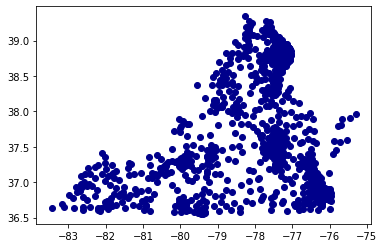

In [ ]:
import matplotlib.image as mpimg
import numpy as np

no_na= outer_merged.dropna()

import matplotlib.pyplot as plt
for index, row in no_na.iterrows():
  plt.scatter(x=row['lon'], y=row['lat'], c='DarkBlue')
plt.show()

Data Cleaning

In [ ]:
#since data is all in virginia, we will drop state and only include county as categorical 
#we will also drop CensusTract, which is unique to each row 

# removing all rows with NAs** for preliminary exploration
outer_merged= outer_merged.dropna()


cat_attribs = list(outer_merged[['County']])
#num_attribs = outer_merged['lon']
num_attribs = outer_merged.drop(['County', "CensusTract"	,"State_x"], axis=1)
#num_attribs= list(numeric_columns)


# **
num_attribs = num_attribs.select_dtypes(exclude="object").columns

In [ ]:
#PIPELINE for clustering 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
#print(housing_num.info())

num_pipeline = Pipeline([
                         ('imputer' , SimpleImputer(strategy = "median")),
                         ('std_scaler',StandardScaler()),
                                       
])


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])



food_desert_prepared_cluster = full_pipeline.fit_transform(outer_merged)

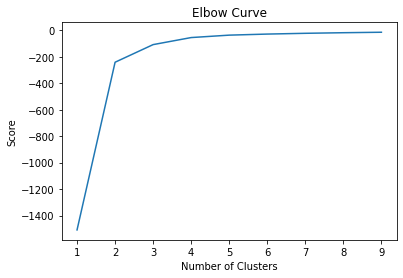

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# what value of k should we look into?
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['lat']]
X_axis = df[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


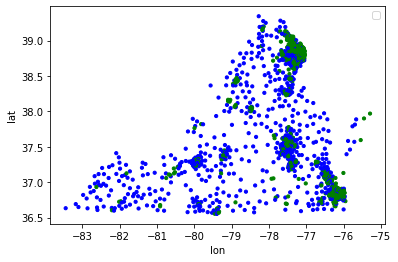

In [ ]:
kmeans = KMeans(n_clusters = 2, init ='random')
kmeans.fit(food_desert_prepared_cluster) # Compute k-means clustering.

outer_merged['cluster_label'] = kmeans.fit_predict(food_desert_prepared_cluster)
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(food_desert_prepared_cluster) # Labels of each point

colormap = np.array(['g', 'b'])

outer_merged.plot.scatter(x = 'lon', y = 'lat', c=colormap[labels], s=10)
plt.legend()
plt.show()
# plot.scatter(centers[:, 0][0],centers[:, 0][1], c='pink')
# plot.scatter(centers[:, 1][0],centers[:, 1][1], c='blue')
# need to plot final centroids. fix later

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [ ]:
kmeans.inertia_

210327.6741523204

**Kmeans++**


In [ ]:
kmeans = KMeans(n_clusters=2, init="k-means++", n_init=1, random_state=42)
kmeans.fit(food_desert_prepared_cluster)
kmeans.inertia_

210328.89500427002

**Mini Batch Kmeans**

In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatch_kmeans.fit(food_desert_prepared_cluster)
minibatch_kmeans.inertia_

212167.93769869176

##Regression

In [ ]:
# Regression Dataset- made up of demographic features: 
# (those that don't involve other definitions of food deserts, we don't want the algorithm to cheat!)
regress_data= food_access_va[['lalowi1share', 'Urban', 'POP2010', 'OHU2010', 'PCTGQTRS', 'PovertyRate', 'MedianFamilyIncome', 'TractLOWI', 
                              'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 
                              'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP']]

regress_data

,lalowi1share,Urban,POP2010,OHU2010,PCTGQTRS,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
67498,0.138221,0,2941,1417,0.005440,11.4,68454,873,454,802,2804,23,17,0,8,89,49,141,66
67499,0.351279,0,6156,2630,0.002437,20.4,49257,2238,1234,1141,3985,1902,39,13,25,192,179,110,275
67500,0.558583,0,2335,960,0.000000,21.0,36129,1307,521,413,1735,443,9,2,3,143,152,111,228
67501,0.390404,0,6234,2225,0.047482,16.8,48836,3234,1530,914,3115,2313,30,10,24,742,1486,170,495
67502,0.564322,0,2849,1141,0.003510,22.4,41750,1422,685,440,1769,745,27,7,25,276,405,138,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,0.001739,1,6657,2536,0.008262,24.3,35220,4839,1732,703,4160,1244,92,0,35,1126,1712,453,613
69394,0.083512,1,3417,1588,0.003805,9.4,75078,913,623,620,2923,247,31,0,6,210,249,137,109
69395,0.071944,1,5736,2627,0.002441,9.3,103581,1258,1144,1098,4972,303,233,3,15,210,213,157,50
69396,0.018044,1,5066,1638,0.174299,17.2,47255,1735,1057,602,3592,568,62,1,20,823,950,217,233


In [ ]:
# regression label 

regress_data[['lalowi1share']]

,lalowi1share
67498,0.138221
67499,0.351279
67500,0.558583
67501,0.390404
67502,0.564322
...,...
69393,0.001739
69394,0.083512
69395,0.071944
69396,0.018044


In [ ]:
cencus_tract_id= food_access_va[['CensusTract']]
cencus_tract_id.head()

,CensusTract
67498,51001090100
67499,51001090200
67500,51001090300
67501,51001090400
67502,51001090500


In [ ]:
#train and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(regress_data, test_size=.2, random_state =42)
test_set.head()

,lalowi1share,Urban,POP2010,OHU2010,PCTGQTRS,PovertyRate,MedianFamilyIncome,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
68720,0.324487,0,4233,1821,0.00000,8.0,48750,1822,873,744,4168,24,6,2,10,23,34,102,325
67609,0.000000,1,4,3,0.00000,0.0,0,0,0,1,2,0,0,0,0,2,2,0,0
68052,0.000000,1,10,2,0.00000,0.0,0,0,6,0,8,0,1,0,0,1,0,0,0
68024,0.054471,1,6677,2059,0.00000,3.2,107969,1176,2053,272,3558,713,1585,7,19,795,1146,47,99
68808,0.249021,1,4351,1546,0.13698,67.3,59000,2855,103,68,2681,355,1087,1,2,225,244,129,5


In [ ]:
#PIPELINE for regression (label: lalowi1share)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

x_train = train_set
y_train = x_train["lalowi1share"]
x_train = x_train.drop("lalowi1share",axis =1 )

# preparing test set
x_test = test_set
y_test = x_test["lalowi1share"]
x_test = x_test.drop("lalowi1share",axis=1)

temp = regress_data
temp = temp.drop("Urban",axis = 1)
temp = temp.drop("lalowi1share",axis = 1)
cat_attribs = ["Urban"]
num_attribs = list(temp)
# print(num_attribs)
# print(cat_attribs)


num_pipeline = Pipeline([
                         ('imputer' , SimpleImputer(strategy = "median")),
                         ('std_scaler',StandardScaler()),
                                       
])


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])



food_desert_prepared = full_pipeline.fit_transform(x_train)
food_desert_test_prepared = full_pipeline.transform(x_test)

Linear Regression

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# functinon to display models' scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(food_desert_prepared, y_train)

# validation set
lin_scores = cross_val_score(lin_reg, food_desert_prepared, y_train,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.10393937 0.09630715 0.10002371 0.11097802 0.09720051]
Mean: 0.1016897521397053
Standard deviation: 0.00535227312582072


Elastic Net

In [ ]:
regr_elastic = ElasticNet(random_state=42)
regr_elastic.fit(food_desert_prepared, y_train)

#validation set
scores = cross_val_score(regr_elastic, food_desert_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=5) 

elastic_rmse_scores = np.sqrt(-scores)
display_scores(elastic_rmse_scores)

Scores: [0.14860757 0.14790156 0.15884834 0.16004672 0.13514075]
Mean: 0.1501089906491322
Standard deviation: 0.009014543974434323


Lasso

In [ ]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=0.1)
lasso_reg.fit(food_desert_prepared, y_train)

#validation set
lasso_scores = cross_val_score(lasso_reg, food_desert_prepared, y_train,
                                scoring="neg_mean_squared_error", cv=5)
lasso_rmse_scores = np.sqrt(-lasso_scores)
display_scores(lasso_rmse_scores)

Scores: [0.14860757 0.14790156 0.15884834 0.16004672 0.13514075]
Mean: 0.1501089906491322
Standard deviation: 0.009014543974434323


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(food_desert_prepared, y_train)

#validation set
forest_scores = cross_val_score(forest_reg, food_desert_prepared, y_train,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.09568651 0.07861126 0.08511902 0.09622439 0.08667329]
Mean: 0.0884628934559659
Standard deviation: 0.0066911916378041445


Summary of model performance before hyperparameter search

In [ ]:
#summary of model scores

# initialize list of lists
allScores = [['Linear Regression', lin_rmse_scores.mean(), lin_rmse_scores.std()], 
             ['Random Forest Regressor', forest_rmse_scores.mean(), forest_rmse_scores.std()], 
             ['Elastic Net', elastic_rmse_scores.mean(), elastic_rmse_scores.std()],
             ['Lasso', lasso_rmse_scores.mean(), lasso_rmse_scores.std()]]
 
# Create the pandas DataFrame
df_allScores = pd.DataFrame(allScores, columns = ['Model', 'Mean RMSE', 'RMSE Standard Deviation'])
 
# print dataframe.
df_allScores

,Model,Mean RMSE,RMSE Standard Deviation
0,Linear Regression,0.101690,0.005352
1,Random Forest Regressor,0.088463,0.006691
2,Elastic Net,0.150109,0.009015
3,Lasso,0.150109,0.009015


Fine Tuning Chosen Model: 

Searching for hyperparameter(s) using GridSearchCV - 
model with the lowest validation errors:


RandomForestRegressor 

**GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
# training 18 (hyperparams) * 5 rounds (folds)
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of 90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(food_desert_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
cvres_grid = grid_search.cv_results_
for mean_score, params in zip(cvres_grid["mean_test_score"], cvres_grid["params"]):
    print(np.sqrt(-mean_score), params)

0.10862861351711406 {'max_features': 2, 'n_estimators': 3}
0.0959892940674481 {'max_features': 2, 'n_estimators': 10}
0.09165567861422791 {'max_features': 2, 'n_estimators': 30}
0.10190271051067197 {'max_features': 4, 'n_estimators': 3}
0.09363428086538621 {'max_features': 4, 'n_estimators': 10}
0.08914948146183996 {'max_features': 4, 'n_estimators': 30}
0.10280505322339135 {'max_features': 6, 'n_estimators': 3}
0.09137041957251178 {'max_features': 6, 'n_estimators': 10}
0.08813208789522006 {'max_features': 6, 'n_estimators': 30}
0.10083471538114872 {'max_features': 8, 'n_estimators': 3}
0.09287061986981163 {'max_features': 8, 'n_estimators': 10}
0.08981213959467717 {'max_features': 8, 'n_estimators': 30}
0.10316687793881395 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.09401215717796382 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.10621727050176627 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.09137531279648198 {'bootstrap': False, 'max_f

In [ ]:
# best hyperparameter combo found:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

**RandomizedSearchCV**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42) #RUN 20 TIMES WITH 5 FOLDS
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(food_desert_prepared, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f755bbcba50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f755bbcba10>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.08716248473701835 {'max_features': 7, 'n_estimators': 180}
0.0904161660542772 {'max_features': 5, 'n_estimators': 15}
0.08877652551203098 {'max_features': 3, 'n_estimators': 72}
0.08933607465390511 {'max_features': 5, 'n_estimators': 21}
0.08770508163842056 {'max_features': 7, 'n_estimators': 122}
0.08883568952376379 {'max_features': 3, 'n_estimators': 75}
0.08861018418324712 {'max_features': 3, 'n_estimators': 88}
0.08675331413383686 {'max_features': 5, 'n_estimators': 100}
0.08848455803447089 {'max_features': 3, 'n_estimators': 150}
0.10762633418123223 {'max_features': 5, 'n_estimators': 2}
0.08734135183004132 {'max_features': 4, 'n_estimators': 158}
0.08703019806708222 {'max_features': 6, 'n_estimators': 130}
0.08981811549403597 {'max_features': 4, 'n_estimators': 21}
0.09291573325251319 {'max_features': 1, 'n_estimators': 58}
0.08730658158091595 {'max_features': 6, 'n_estimators': 89}
0.092991852764694 {'max_features': 1, 'n_estimators': 59}
0.08718015760816039 {'max_features': 7

In [ ]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=175, random_state=42)

**Evaluating the Final Model**

In [ ]:
# TESTING - after tuning, finally teting on UNFORSEEN DATA 
final_model = rnd_search.best_estimator_
final_predictions = final_model.predict(food_desert_test_prepared)

final_mse = mean_squared_error(final_predictions,y_test)
final_rmse = np.sqrt(final_mse)
final_rmse

0.0956711434256795

## Predictor

In [ ]:
# example of user prediction on hypothetical land tract 

# 1 for urban, 0 for rural
Urban = 1 

# 1 for rural, 0 for urban 
Rural = 0

# Population count from 2010 census
POP2010 = 3000

# Occupied housing unit count from 2010 census
OHU2010 = 2000

# Percent of tract population residing in group quarters
PCTGQTRS = 0

# Share of the tract population living with income at or below the Federal poverty thresholds for family size
PovertyRate = 20

# Tract median family income
MedianFamilyIncome = 29000

# Total count of children age 0-17 in tract 
TractKids = 500

# Total count of seniors age 65+ in tract 
TractSeniors = 400

# Total count of White population in tract 
TractWhite= 800

# Total count of Black population in tract 
TractBlack = 1000

# Total count of Asian population in tract
TractAsian = 200

# Total count of Native Hawaiian and Other Pacific Islander population in tract 
TractNHOPI = 200

# Total count of American Indian and Alaska Native population in tract 
TractAIAN = 100

# Total count of Other/Multiple race population in tract 
TractOMultir = 400

# Total count of Hispanic or Latino population in tract 
TractHispanic = 300

# Total count of housing units without a vehicle in tract 
TractHUNV = 200

# Total count of housing units receiving SNAP benefits in tract 
TractSNAP = 300

area_array= [[Urban, Rural, POP2010, OHU2010, PCTGQTRS, PovertyRate, MedianFamilyIncome, (PovertyRate/100) * POP2010, 
                              TractKids, TractSeniors, TractWhite, TractBlack, TractAsian, TractNHOPI, TractAIAN, 
                              TractOMultir, TractHispanic, TractHUNV, TractSNAP]]

area_array = pd.DataFrame(area_array, columns = ['Urban', 'Rural', 'POP2010', 'OHU2010', 'PCTGQTRS', 'PovertyRate', 'MedianFamilyIncome', 
                                                         'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 
                                                         'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP'])

predict_tool_pipeline = num_pipeline.fit_transform(area_array)
predict_tool_prediction= rnd_search.best_estimator_.predict(predict_tool_pipeline)

predict_tool_prediction_percent_rounded = (round(((predict_tool_prediction[0])*100), 2))
predict_tool_prediction_percent_rounded

print("With this specific demographic information, our model predicts that ", 
      predict_tool_prediction_percent_rounded, "% of individuals who live in this tract live in a food desert.")

With this specific demographic information, our model predicts that  9.09 % of individuals who live in this tract live in a food desert.
